In [ ]:
import torch
from torch import nn

device = 'cuda'
dtype = torch.float32
B, S = 100, 128
H, D = 8, 64
E = H*D
Vocab = 30552

torch.manual_seed(0)

# randomly generate inputs
input_ids = torch.randint(0, Vocab, (B,S), device=device)

#Create embeddings for Vacab size and Embed dimension
embed = nn.Embedding(Vocab, E).to(device=device, dtype=dtype)
#Linear projections of Q, K,V
qkv_proj = nn.Linear(E, 3*E, bias=False).to(device=device, dtype=dtype)
x = embed(input_ids)
qkv = qkv_proj(x)
q, k, v = qkv.chunk(3, dim=-1)

q = q.view(B,S,H,D).permute(0, 2,1,3).contiguous()
k = k.view(B,S,H,D).permute(0, 2,1,3).contiguous()
v = v.view(B,S,H,D).permute(0, 2,1,3).contiguous()

print("input_ids:", input_ids.shape)
print("x(emb):", x.shape)
print("q, k,v:", q.shape, k.shape, v.shape)



input_ids: torch.Size([100, 128])
x(emb): torch.Size([100, 128, 512])
q, k,v: torch.Size([100, 8, 128, 64]) torch.Size([100, 8, 128, 64]) torch.Size([100, 8, 128, 64])


In [ ]:
import torch
import torch.nn as nn

def pytorch_attention(q, k,v):
  B, H, S,D = q.shape
  scale = D **-0.5
  attn_scores = torch.matmul(q, k.transpose(2,-1))*scale
  causal_mask = torch.triu(torch.ones((S,S), device=q.device, dtype = torch.bool), diagonal=1)
  attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
  attn_probs = torch.softmax(attn_scores, dim=-1)
  output = torch.matmul(attn_probs, v)
  return output

output_pt = pytorch_attention(q, k,v)
print("Output shape(PyTorch)", output_pt.shape)




Output shape(PyTorch) torch.Size([100, 8, 128, 64])


In [ ]:
import torch
import triton
import triton.language as tl

@triton.jit
def flashattn2_forward(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    stride_qb, stride_qh, stride_qs, stride_qd,
    stride_kb, stride_kh, stride_ks, stride_kd,
    stride_vb, stride_vh, stride_vs, stride_vd,
    stride_ob, stride_oh, stride_os, stride_od,
    B, H, S,
    D: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr
):
    # Program and block identification
    batch_id = tl.program_id(0)
    head_id  = tl.program_id(1)
    start_m  = tl.program_id(2) * BLOCK_M

    # Offsets for the current query block
    offs_m = start_m + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_D)

    # Pointer setup for Q and Output
    Q_ptr_block = (Q_ptr + batch_id * stride_qb + head_id * stride_qh +
                   (offs_m[:, None] * stride_qs) + (offs_d[None, :] * stride_qd))
    O_ptr_block = (Out_ptr + batch_id * stride_ob + head_id * stride_oh +
                   (offs_m[:, None] * stride_os) + (offs_d[None, :] * stride_od))

    # Initialize softmax statistics
    m_i = tl.full((BLOCK_M,), float('-inf'), dtype=tl.float32)
    l_i = tl.zeros((BLOCK_M,), dtype=tl.float32)
    acc = tl.zeros((BLOCK_M, BLOCK_D), dtype=tl.float32)

    # Load the query block
    Q_mask = (offs_m[:, None] < S)
    Q = tl.load(Q_ptr_block, mask=Q_mask, other=0.0)

    scale = 1.0 / tl.sqrt(float(D))

    # Causal loop over key/value blocks
    for start_n in range(0, start_m + BLOCK_M, BLOCK_N):
        offs_k = start_n + tl.arange(0, BLOCK_N)

        # Pointer setup for K and V
        K_ptr_block = (K_ptr + batch_id * stride_kb + head_id * stride_kh +
                       (offs_k[:, None] * stride_ks) + (offs_d[None, :] * stride_kd))
        V_ptr_block = (V_ptr + batch_id * stride_vb + head_id * stride_vh +
                       (offs_k[:, None] * stride_vs) + (offs_d[None, :] * stride_vd))

        # Boundary mask for valid key positions
        K_mask = (offs_k < S)

        # Load K and V blocks
        K = tl.load(K_ptr_block, mask=K_mask[:, None], other=0.0)
        V = tl.load(V_ptr_block, mask=K_mask[:, None], other=0.0)

        # Compute attention scores
        scores = tl.dot(Q, tl.trans(K)) * scale

        # Combined masking: causal + boundary
        causal_mask = (offs_m[:, None] >= offs_k[None, :])  # Allow current and past
        boundary_mask = K_mask[None, :]  # Valid key positions
        valid_mask = causal_mask & boundary_mask

        # Apply masking
        scores = tl.where(valid_mask, scores, float("-inf"))

        # Check if any valid scores exist for each query
        has_valid = tl.sum(valid_mask.to(tl.int32), axis=1) > 0

        # Online Softmax Update - handle all-masked case
        m_ij = tl.max(scores, axis=1)
        # If all scores are -inf, set m_ij to 0 to avoid NaN
        m_ij = tl.where(has_valid, m_ij, 0.0)

        p_ij = tl.exp(scores - m_ij[:, None])
        # Zero out probabilities for rows with no valid scores
        p_ij = tl.where(has_valid[:, None], p_ij, 0.0)

        l_ij = tl.sum(p_ij, axis=1)
        acc_ij = tl.dot(p_ij.to(V.dtype), V)

        # Update running statistics
        m_i_new = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - m_i_new)
        beta = tl.exp(m_ij - m_i_new)

        # Handle the case where beta might be NaN due to -inf - (-inf)
        # When has_valid is False, beta should be 0
        beta = tl.where(has_valid, beta, 0.0)

        l_i_new = alpha * l_i + beta * l_ij
        acc = acc * alpha[:, None] + acc_ij * beta[:, None]

        m_i = m_i_new
        l_i = l_i_new

    # Final normalization with safe division
    O = tl.zeros((BLOCK_M, BLOCK_D), dtype=acc.dtype)
    # Only divide where l_i > 0 to avoid 0/0 = NaN
    O = tl.where(l_i[:, None] > 0, acc / l_i[:, None], O)

    # Write the final output block
    tl.store(O_ptr_block, O, mask=Q_mask)

In [ ]:
def run_flashattn2_triton (
    q : torch.Tensor, k : torch.Tensor, v : torch.Tensor,
    BLOCK_M : int =128, BLOCK_N : int = 64
) -> torch.Tensor:

  assert q.is_cuda and q.dtype == torch.float32
  B,H, S,D = q.shape
  out = torch.empty_like(q)

  def strides(x):
    return x.stride(0), x.stride(1), x.stride(2), x.stride(3)

  sqb, sqh, sqs, sqd = strides(q)
  skb, skh, sks, skd = strides(k)
  svb, svh, svs, svd = strides(v)
  sob, soh, sos, sod = strides(out)

  grid = (B,H, triton.cdiv(S, BLOCK_M))

  flashattn2_forward[grid](
      q, k, v, out,
      sqb, sqh, sqs, sqd,
      skb, skh, sks, skd,
      svb, svh, svs, svd,
      sob, soh, sos, sod,
      B, H, S,D,
      BLOCK_M = BLOCK_M,
      BLOCK_N = BLOCK_N,
      BLOCK_D = D
  )

  return out



In [ ]:
import torch

B,H,S,D = 100,8,128,64

q = torch.randn(B,H,S,D, device='cuda', dtype = torch.float32)
k = torch.randn(B,H,S,D, device='cuda', dtype = torch.float32)
v = torch.randn(B, H, S, D, device='cuda', dtype=torch.float32)
print("Q shape:", q.shape)

out_pt = pytorch_attention(q, k, v)
out_triton = run_flashattn2_triton(q, k, v)

print("Output shape OK:", out_pt.shape == out_triton.shape)

print("Numerical match:", torch.allclose(out_pt, out_triton, atol=1e-2, rtol=1e-2))
print("Max abs error:", (out_pt - out_triton).abs().max().item())

print("out_pt[0, 0, 0, :5]:", out_pt[0, 0, 0, :5])
print("out_triton[0, 0, 0, :5]:", out_triton[0, 0, 0, :5])
print("diff:", (out_pt - out_triton)[0, 0, 0, :5])

Q shape: torch.Size([100, 8, 128, 64])
Output shape OK: True
Numerical match: True
Max abs error: 0.0036656856536865234
out_pt[0, 0, 0, :5]: tensor([ 0.7897,  0.8691, -0.0102, -0.0217,  0.5066], device='cuda:0')
out_triton[0, 0, 0, :5]: tensor([ 0.7896,  0.8687, -0.0102, -0.0217,  0.5063], device='cuda:0')
diff: tensor([ 1.3083e-04,  3.9816e-04, -6.4345e-06, -2.5146e-06,  2.6381e-04],
       device='cuda:0')


In [ ]:
import torch
import torch.cuda.nvtx as nvtx # Import NVTX
import matplotlib.pyplot as plt

def benchmark_attention(B=100, H=8, D=64, seqs=[64, 128, 256, 512, 1024, 2048]):
    device = 'cuda'
    results = []
    for S in seqs:
        q = torch.randn(B, H, S, D, device=device)
        k = torch.randn_like(q)
        v = torch.randn_like(q)

        # Warm-up
        _ = pytorch_attention(q, k, v); torch.cuda.synchronize()
        _ = run_flashattn2_triton(q, k, v, BLOCK_M=64, BLOCK_N=64); torch.cuda.synchronize()

        # Time PyTorch with NVTX range
        nvtx.range_push(f"PyTorch S={S}")
        start, end = torch.cuda.Event(True), torch.cuda.Event(True)
        start.record(); _ = pytorch_attention(q, k, v); end.record()
        torch.cuda.synchronize()
        t_pt = start.elapsed_time(end)
        nvtx.range_pop()

        # Time Triton with NVTX range
        nvtx.range_push(f"Triton S={S}")
        start.record(); _ = run_flashattn2_triton(q, k, v, BLOCK_M=64, BLOCK_N=64); end.record()
        torch.cuda.synchronize()
        t_tr = start.elapsed_time(end)
        nvtx.range_pop()

        speedup = t_pt / t_tr
        print(f"S={S:4d} | PyTorch: {t_pt:6.2f}ms | Triton: {t_tr:6.2f}ms | Speedup: {speedup:4.1f}×")
        results.append((S, t_pt, t_tr, speedup))
    return results

S=  64 | PyTorch:   0.54ms | Triton:   0.26ms | Speedup:  2.1×
S= 128 | PyTorch:   0.88ms | Triton:   0.32ms | Speedup:  2.8×
S= 256 | PyTorch:   2.82ms | Triton:   0.59ms | Speedup:  4.8×
S= 512 | PyTorch:  10.84ms | Triton:   1.59ms | Speedup:  6.8×
S=1024 | PyTorch:  40.50ms | Triton:   4.08ms | Speedup:  9.9×
S=2048 | PyTorch: 160.94ms | Triton:  14.63ms | Speedup: 11.0×


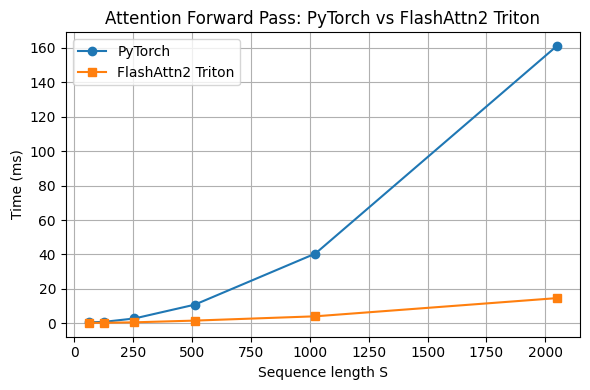

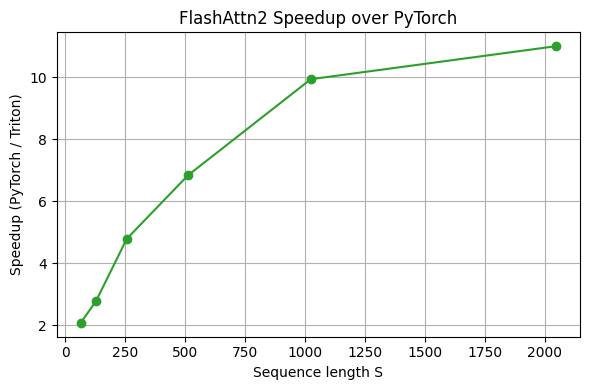

In [ ]:
bench = benchmark_attention()

# Unpack for plotting
Ss, t_pts, t_trs, speedups = zip(*bench)

# Plot absolute times
plt.figure(figsize=(6,4))
plt.plot(Ss, t_pts, marker='o', label='PyTorch')
plt.plot(Ss, t_trs, marker='s', label='FlashAttn2 Triton')
plt.xlabel('Sequence length S')
plt.ylabel('Time (ms)')
plt.title('Attention Forward Pass: PyTorch vs FlashAttn2 Triton')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot speedup
plt.figure(figsize=(6,4))
plt.plot(Ss, speedups, marker='o', color='tab:green')
plt.xlabel('Sequence length S')
plt.ylabel('Speedup (PyTorch / Triton)')
plt.title('FlashAttn2 Speedup over PyTorch')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Check Colab's OS and architecture to get the correct download link
!cat /etc/os-release | grep "VERSION_ID"
!echo "Machine's architecture: `uname -i`"

# Download and install Nsight Systems (example for Ubuntu 22.04)
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt update
!apt install ./nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
!apt --fix-broken install


VERSION_ID="22.04"
Machine's architecture: x86_64
--2025-08-10 22:35:23--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.213.43.199, 23.213.43.207
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.213.43.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317705436 (303M) [application/x-deb]
Saving to: ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’

nsight-systems-2023 100%[===================>] 302.99M  4.05MB/s    in 62s     

2025-08-10 22:36:28 (4.86 MB/s) - ‘nsight-systems-2023.2.3_2023.2.3.1001-1_amd64.deb’ saved [317705436/317705436]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-se

2. **Run with `nsys`**: Once installed, you can run your Python script or notebook cells using the `nsys profile` command followed by `python your_script_name.py` or the command to execute your notebook. In Colab, you can use the `run` command with the notebook path.

In [ ]:
%%writefile profile_attention.py

import torch
import torch.nn as nn
import triton
import triton.language as tl
import torch.cuda.nvtx as nvtx

#================================================#
#  PASTE THE REQUIRED FUNCTION DEFINITIONS HERE  #
#================================================#

# --- PyTorch Attention Definition ---
def pytorch_attention(q, k,v):
  B, H, S,D = q.shape
  scale = D **-0.5
  attn_scores = torch.matmul(q, k.transpose(2,-1))*scale
  causal_mask = torch.triu(torch.ones((S,S), device=q.device, dtype = torch.bool), diagonal=1)
  attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
  attn_probs = torch.softmax(attn_scores, dim=-1)
  output = torch.matmul(attn_probs, v)
  return output

# --- Triton Kernel Definition ---
@triton.jit
def flashattn2_forward(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    stride_qb, stride_qh, stride_qs, stride_qd,
    stride_kb, stride_kh, stride_ks, stride_kd,
    stride_vb, stride_vh, stride_vs, stride_vd,
    stride_ob, stride_oh, stride_os, stride_od,
    B, H, S,
    D: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr
):
    # This is the full, correct Triton kernel from your notebook
    batch_id = tl.program_id(0)
    head_id  = tl.program_id(1)
    start_m  = tl.program_id(2) * BLOCK_M
    offs_m = start_m + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_D)
    Q_ptr_block = (Q_ptr + batch_id * stride_qb + head_id * stride_qh +
                   (offs_m[:, None] * stride_qs) + (offs_d[None, :] * stride_qd))
    O_ptr_block = (Out_ptr + batch_id * stride_ob + head_id * stride_oh +
                   (offs_m[:, None] * stride_os) + (offs_d[None, :] * stride_od))
    m_i = tl.full((BLOCK_M,), float('-inf'), dtype=tl.float32)
    l_i = tl.zeros((BLOCK_M,), dtype=tl.float32)
    acc = tl.zeros((BLOCK_M, BLOCK_D), dtype=tl.float32)
    Q_mask = (offs_m[:, None] < S)
    Q = tl.load(Q_ptr_block, mask=Q_mask, other=0.0)
    scale = 1.0 / tl.sqrt(float(D))
    for start_n in range(0, start_m + BLOCK_M, BLOCK_N):
        offs_k = start_n + tl.arange(0, BLOCK_N)
        K_ptr_block = (K_ptr + batch_id * stride_kb + head_id * stride_kh +
                       (offs_k[:, None] * stride_ks) + (offs_d[None, :] * stride_kd))
        V_ptr_block = (V_ptr + batch_id * stride_vb + head_id * stride_vh +
                       (offs_k[:, None] * stride_vs) + (offs_d[None, :] * stride_vd))
        K_mask = (offs_k < S)
        K = tl.load(K_ptr_block, mask=K_mask[:, None], other=0.0)
        V = tl.load(V_ptr_block, mask=K_mask[:, None], other=0.0)
        scores = tl.dot(Q, tl.trans(K)) * scale
        causal_mask = (offs_m[:, None] >= offs_k[None, :])
        boundary_mask = K_mask[None, :]
        valid_mask = causal_mask & boundary_mask
        scores = tl.where(valid_mask, scores, float("-inf"))
        has_valid = tl.sum(valid_mask.to(tl.int32), axis=1) > 0
        m_ij = tl.max(scores, axis=1)
        m_ij = tl.where(has_valid, m_ij, 0.0)
        p_ij = tl.exp(scores - m_ij[:, None])
        p_ij = tl.where(has_valid[:, None], p_ij, 0.0)
        l_ij = tl.sum(p_ij, axis=1)
        acc_ij = tl.dot(p_ij.to(V.dtype), V)
        m_i_new = tl.maximum(m_i, m_ij)
        alpha = tl.exp(m_i - m_i_new)
        beta = tl.exp(m_ij - m_i_new)
        beta = tl.where(has_valid, beta, 0.0)
        l_i_new = alpha * l_i + beta * l_ij
        acc = acc * alpha[:, None] + acc_ij * beta[:, None]
        m_i = m_i_new
        l_i = l_i_new
    O = tl.zeros((BLOCK_M, BLOCK_D), dtype=acc.dtype)
    O = tl.where(l_i[:, None] > 0, acc / l_i[:, None], O)
    tl.store(O_ptr_block, O, mask=Q_mask)

# --- Triton Launcher Definition ---
def run_flashattn2_triton (
    q : torch.Tensor, k : torch.Tensor, v : torch.Tensor,
    BLOCK_M : int =128, BLOCK_N : int = 64
) -> torch.Tensor:
  assert q.is_cuda and q.dtype == torch.float32
  B,H, S,D = q.shape
  out = torch.empty_like(q)
  def strides(x):
    return x.stride(0), x.stride(1), x.stride(2), x.stride(3)
  sqb, sqh, sqs, sqd = strides(q)
  skb, skh, sks, skd = strides(k)
  svb, svh, svs, svd = strides(v)
  sob, soh, sos, sod = strides(out)
  grid = (B,H, triton.cdiv(S, BLOCK_M))
  flashattn2_forward[grid](
      q, k, v, out,
      sqb, sqh, sqs, sqd,
      skb, skh, sks, skd,
      svb, svh, svs, svd,
      sob, soh, sos, sod,
      B, H, S,D,
      BLOCK_M = BLOCK_M,
      BLOCK_N = BLOCK_N,
      BLOCK_D = D
  )
  return out

# --- Benchmark Function ---
def benchmark_attention(B=100, H=8, D=64, seqs=[64, 128, 256, 512, 1024, 2048]):
    # This function remains the same, but it can now find the attention functions defined above
    device = 'cuda'
    for S in seqs:
        q = torch.randn(B, H, S, D, device=device)
        k = torch.randn_like(q)
        v = torch.randn_like(q)
        #_ = pytorch_attention(q, k, v); torch.cuda.synchronize()
        _ = run_flashattn2_triton(q, k, v, BLOCK_M=128, BLOCK_N=64); torch.cuda.synchronize()

        #nvtx.range_push(f"PyTorch S={S}")
        #_ = pytorch_attention(q, k, v)
        #nvtx.range_pop()

        nvtx.range_push(f"Triton S={S}")
        _ = run_flashattn2_triton(q, k, v, BLOCK_M=128, BLOCK_N=64)
        nvtx.range_pop()

if __name__ == '__main__':
    print("Running self-contained benchmark script...")
    benchmark_attention()
    print("Benchmark finished.")

Writing profile_attention.py


In [ ]:
# This command tells ncu to find the NVTX range named "Triton S=1024"
# and profile the kernels inside it. We save the report to a file.

!ncu --set detailed --nvtx --nvtx-include "Triton S=1024/" -o triton_kernel_report_full_M128_N64.ncu-rep python profile_attention.py

#!ncu --set full --nvtx --nvtx-include "Triton S=1024/" -o triton_kernel_report_full_best_M_N.ncu-rep python profile_attention.py

Running self-contained benchmark script...
==PROF== Connected to process 929 (/usr/bin/python3.11)
Traceback (most recent call last):
  File "/content/profile_attention.py", line 135, in <module>
    benchmark_attention()
  File "/content/profile_attention.py", line 123, in benchmark_attention
    _ = run_flashattn2_triton(q, k, v, BLOCK_M=128, BLOCK_N=64); torch.cuda.synchronize()
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/profile_attention.py", line 101, in run_flashattn2_triton
    flashattn2_forward[grid](
  File "/usr/local/lib/python3.11/dist-packages/triton/runtime/jit.py", line 330, in <lambda>
    return lambda *args, **kwargs: self.run(grid=grid, warmup=False, *args, **kwargs)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/triton/runtime/jit.py", line 568, in run
    device = driver.active.get_current_device()
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

3. **Download the report**: After the profiling is complete, a report file (e.g., `attention_profile.qdrep`) will be generated. You can download this file from the Colab file explorer (the folder icon on the left sidebar) and open it with the Nsight Systems UI on your local machine for detailed analysis.